# Scratching Gibbs sampler for Bayesian regression

## Data description

100 points(yi,i=1,…,N) generated from a mixture distribution of two normal distributions with R.


```R
N      <- 100
a_true <- 0.4
mean1  <- 0
mean2  <- 3
sd1    <- 1
sd2    <- 1
Y      <- c(rnorm((1-a_true)*N, mean1, sd1), rnorm(a_true*N, mean2, sd2))
data   <- list(N=N, Y=Y)

write.table(Y, file="points.csv", sep=",", row.names=F, col.names=F)
```

## Model (single normal distribution)

Here we wish to find the posterior distributions of the coefficients mu(the mean) and s(the standard deviation) of a single normal distribution. The model can be written as

$$y_i \sim \mathcal{N}(\mu, \sigma^2)$$

The likelihood for this model may be written as the product over N iid observations

$$L(y_1, \ldots, y_N | \mu, \sigma) = \prod_{i = 1}^N \mathcal{N}(\mu, \sigma^2)$$

We place priors on mu and s.

$$\mu \sim uniform(-\infty, \infty) $$

$$\sigma \sim uniform(0, \infty) $$

and then $$ p(\mu)=constant$$ $$p(\sigma) = constant $$

## Pythonic setup

In [1]:
import numpy as np
np.random.seed(0)

import scipy as sp

import pandas as pd
pd.set_option('display.width', 200)

% matplotlib inline
from seaborn import plt
plt.rcParams['figure.figsize'] = (10, 5)

## The basis of Gibbs sampling

[Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) works as follows: suppose we have N parameters $ \theta_j, j=1,...,n $, and data X, and we want to find the posterior distribution of $ p(\theta_j | x) $. To do this in a Gibbs sampling regime we need to work out the conditional distributions $ p(\theta_j|\theta_1, ...\theta_{j-1}, \theta_{j+1}, ..., \theta_n, x) $ for all $\theta_j $.

1. Begin with some initial value $ \theta_j^{(i)}$.
2. Sample $ \theta_j^{(i+1)} \sim p(\theta_j|\theta_1^{(i+1)},... \theta_{j-1}^{(i+1)},\theta_{j+1}^{(i)}, ..., \theta_n^{(i)}, x) $ for all j.
3. Repeat the above step.


In step 2, for example, sample $ \theta_1^{(i+1)} \sim p(\theta_j|\theta_2^{(i)}, ..., \theta_n^{(i)}, x) $ for $j=1 $, and sample $ \theta_2^{(i+1)} \sim p(\theta_j|\theta_1^{(i+1)}, \theta_3^{(i)}, ..., \theta_n^{(i)}, x) $ for $j=2$.

## Deriving Gibbs sampler

### Update for mu

I am interested in finding

\begin{eqnarray}
p(\mu | \sigma, Y) &=& \frac {p(\mu, \sigma, Y)} {p(\sigma, Y)} \\
&\propto& p(Y | \mu, \sigma) p(\mu) p(\sigma) \\
&\propto& p(Y | \mu, \sigma) \\
\end{eqnarray}

Note that $p(Y | \mu, \sigma)$ is just the likelihood of the posterior from above. 

If a variable x follows a normal distribution with mean $\mu$ and variance $\sigma^2$ then $ lp(x)$ (the log-dependence on x) is

$$ lp(x) \propto - \frac{1} {2\sigma^2} (x-\mu)^2 \propto - \frac{1} {2\sigma^2}x^2 +  \frac{\mu} {\sigma^2} x $$

So if we can force the log-posterior conditional density into a quadratic form then the coefficient of $x$ will be $ \frac{\mu} {\sigma^2}$ and the coefficient of $ x^2 $ will be $ - \frac{1} {2\sigma^2} $.

Hence $ lp(\mu) $ is 

\begin{eqnarray}
lp(\mu) &\propto& -  \frac {1} {2\sigma^2} \sum_{i=1}^N \left(y_i- \mu \right)^2 \\
&=&  -  \frac {1} {2\sigma^2} \sum_{i=1}^N \left(y_i^2 - 2y_i\mu + \mu^2 \right) \\
&\propto&  -  \frac {N} {2\sigma^2} \mu^2 + \left(\frac{1} {\sigma^2} \sum_{i=1}^N y_i\right)\mu \\
\end{eqnarray}

This expression is quadratic in $\mu$, meaning the conditional sampling density for $\mu$ will also be normal. The coefficient of $ \mu$ is $ \frac{1} {\sigma^2} \sum_{i=1}^N y_i $ while the coefficient of $ \mu^2 $ is $ -  \frac {N} {2\sigma^2}$. This implies the conditional sampling distribution of $ \mu$ is 

$$ \mu | \sigma, Y \sim \mathcal{N}\left( \frac{1} {N} \sum_{i=1}^N (y_i), \frac {\sigma^2} {N} \right)$$

I turn into a python function:

In [2]:
def sample_mu(y, N, s):
    mean = np.sum(y) / N
    variance = s * s / N
    return np.random.normal(mean, np.sqrt(variance))

### Update for s


The probability of $ p(\sigma | \mu, Y) $ is

$$ p(\sigma | \mu, Y) \propto p(Y | \mu, \sigma) $$

and similarly to $ lp(\mu) $, the dependence of the conditional log-posterior $ lp(\sigma) $ is given by

\begin{eqnarray}
lp(\sigma) &=& Nlog\left( \frac {1} {\sqrt{2\pi\sigma^2}}\right) -  \frac {1} {2\sigma^2} \sum_{i=1}^N \left(y_i- \mu \right)^2 \\
&\propto& -Nlog\sigma -  \frac {1} {2\sigma^2} \sum_{i=1}^N \left(y_i- \mu \right)^2 \\
\end{eqnarray}

Here we introduce the Gamma distribution, parametrised by $ \alpha$ and $\beta$. Up to the normalising constant the probability of an observation x under a Gamma density is given by $ p(x; \alpha, \beta) \propto \beta^\alpha x^{\alpha-1}e^{-\beta x} $ ([Gamma distribution:wikipedia](https://en.wikipedia.org/wiki/Gamma_distribution)), therefore the log-dependency of any terms invloving x is given by

$$ lp(x; \alpha, \beta) \propto (\alpha - 1)logx - \beta x $$

Now we change the $ \sigma $ to $\tau = 1/\sigma^2$ (the precision of distribution), and $ lp(\tau) $ is

$$ lp(\tau) \propto \frac{N} {2} log\tau -  \frac {\tau} {2} \sum_{i=1}^N \left(y_i- \mu \right)^2 $$

which has a coefficient of $ \tau $ of $ -  \frac {\sum_{i=1}^N \left(y_i- \mu \right)^2} {2}$ and a coefficient of $log\tau$ of $ \frac {N} { 2} $. If you look at the equation of the log-density of the Gamma distribution above, this implies the $ \tau $ as a conditional samling density of 

$$ \tau | \mu, Y \sim Gamma \left(\frac{N} {2}+1, \frac {\sum_{i=1}^N \left(y_i- \mu \right)^2} {2}  \right) $$

I can now code this into python. np.random.gamma uses the shape and scale parameterisation of a Gamma distribution, where the shape $k = \alpha$ but the scale $\theta=1/\beta $, hence we need to invert our expression for $\beta$ before sampling:

In [3]:
def sample_s(y, N, mu):
    alpha = N / 2 + 1
    residuals = y - mu
    beta = np.sum(residuals * residuals) / 2
    tau = np.random.gamma(alpha, 1 / beta)
    return 1 / np.sqrt(tau)

## Writing the Gibbs sampler

Now we ready to write the Gibbs sampler. Apart from the data we need to supply initial parameter estimates.

In [4]:
init = {"mu": np.random.uniform(-100, 100), "s": np.random.uniform(0, 100)}
print(init)

{'mu': 9.762700785464943, 's': 71.51893663724195}


In [5]:
def gibbs(y, iters, init):
    mu = init["mu"]
    s = init["s"]
    N = len(y)
    
    trace = np.zeros((iters, 2)) ## trace to store values of mu, s
    log_likelihoods = np.zeros((iters, N))
    
    for i in range(iters):
        mu = sample_mu(y, N, s)
        s = sample_s(y, N, mu)
        trace[i, :] = np.array((mu, s))
        
        norm = sp.stats.norm(mu, s)
        log_likelihoods[i, :] = np.array([np.log(norm.pdf(x)) for x in y])
    
    trace = pd.DataFrame(trace)
    trace.columns = ['mu', 's']
    
    log_likelihoods = pd.DataFrame(log_likelihoods)
    
    return trace, log_likelihoods

In [6]:
iters = 1000
y = np.array([float(x) for x in open("points.csv", "r").read().strip().split("\n")])
trace, log_likelihoods = gibbs(y, iters, init)

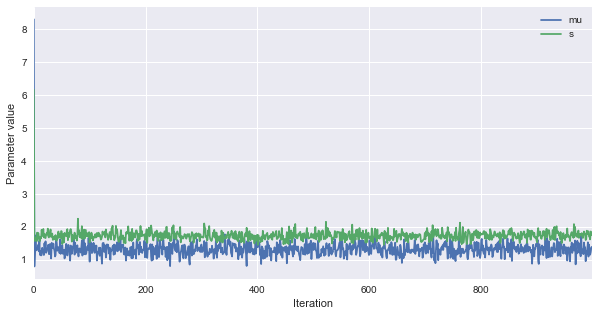

In [7]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

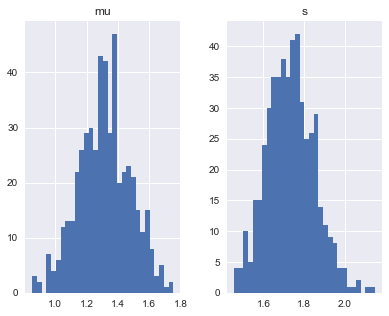

In [8]:
trace_burnt = trace[int(len(trace)/2):]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

I code the WAIC and WBIC functions.

In [9]:
def waic(log_likelihoods):
    training_error = -np.log(np.exp(log_likelihoods).mean(axis=0)).mean()
    functional_variance_div_N = (np.power(log_likelihoods, 2).mean(axis=0) -
                                 np.power(log_likelihoods.mean(axis=0),2)).mean()
    return training_error + functional_variance_div_N

def wbic(log_likelihoods):
    return -log_likelihoods.sum(axis=1).mean()


I can report the descriptive statistics of mu and s, and WAIC/WBIC of current model(single normal distribution).

In [10]:
print(trace_burnt.describe().T)
print("waic:", waic(log_likelihoods))
print("wbic:", wbic(log_likelihoods))

    count      mean       std       min       25%       50%       75%       max
mu  500.0  1.314384  0.165117  0.853459  1.200782  1.316549  1.424733  1.754463
s   500.0  1.733935  0.116493  1.454162  1.655527  1.731396  1.808994  2.147940
waic: 1.98232361435
wbic: 197.277414498


## Compare to Rstan

Finally we run the regression and WAIC/WBIC calculation with R and stan. The result and code are above. The result is similar to that of my scratched Gibbs sampling.

In [11]:
from subprocess import check_output

print(check_output(["Rscript", "run.r"]).decode("utf8"))

# results of the single normal distribution model with Rstan
       mean      se_mean        sd      2.5%      25%      50%      75%    97.5%    n_eff     Rhat
mu 1.307905 0.0009655421 0.1756840 0.9634475 1.189366 1.308708 1.427303 1.652775 33107.17 1.000021
s  1.752572 0.0007169266 0.1265588 1.5272902 1.663740 1.744615 1.832487 2.024040 31162.72 1.000007

                              WAIC     WBIC
single normal dist. model 1.980418 197.2299



In [12]:
for n, i in enumerate(open("run.r", "r"), 1):
    print("{:2d} {}".format(n, i), end="")

 1 options(width=200)
 2 set.seed(1)
 3 
 4 N      <- 100
 5 a_true <- 0.4
 6 mean1  <- 0
 7 mean2  <- 3
 8 sd1    <- 1
 9 sd2    <- 1
10 Y      <- c(rnorm((1-a_true)*N, mean1, sd1), rnorm(a_true*N, mean2, sd2))
11 data   <- list(N=N, Y=Y)
12 
13 write.table(Y, file="points.csv", sep=",", row.names=F, col.names=F)
14 
15 model2 <- "
16 data {
17   int<lower=1> N;
18   vector[N] Y;
19 }
20 
21 parameters {
22   real mu;
23   real<lower=0> s;
24 }
25 
26 model {
27   Y ~ normal(mu, s);
28 }
29 
30 generated quantities {
31   vector[N] log_likelihood;
32   real y_pred;
33   for(n in 1:N)
34     log_likelihood[n] = normal_lpdf(Y[n] | mu, s);
35   y_pred = normal_rng(mu, s);
36 }
37 "
38 
39 sink(file="/dev/null")
40 suppressMessages({
41   library(rstan)
42   fit2 <- stan(model_code=model2, data=data, iter=11000, warmup=1000, seed=123)
43 })
44 sink()
45 cat("# results of the single normal distribution model with Rstan\n")
46 print(summary(fit2)$summary[c("mu", "s"), ])
47 
48 waic <- func

## references

- http://kieranrcampbell.github.io/gibbs-sampling-bayesian-linear-regression/
- http://statmodeling.hatenablog.com/entry/calc-waic-wbic